In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [2]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [3]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [4]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


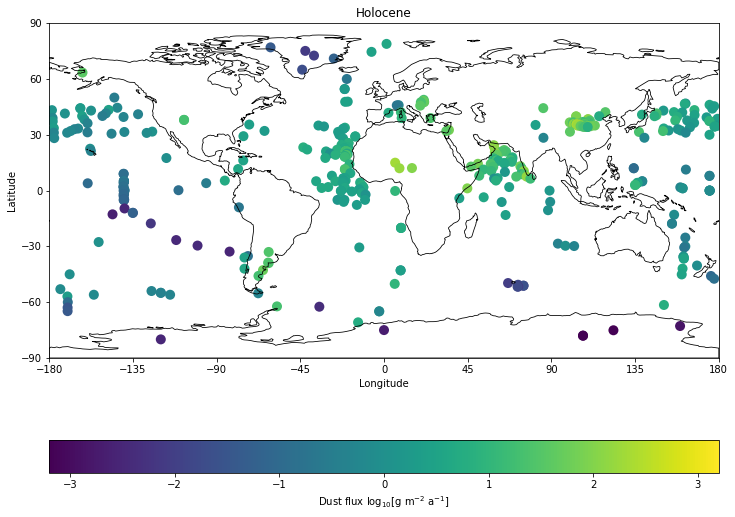

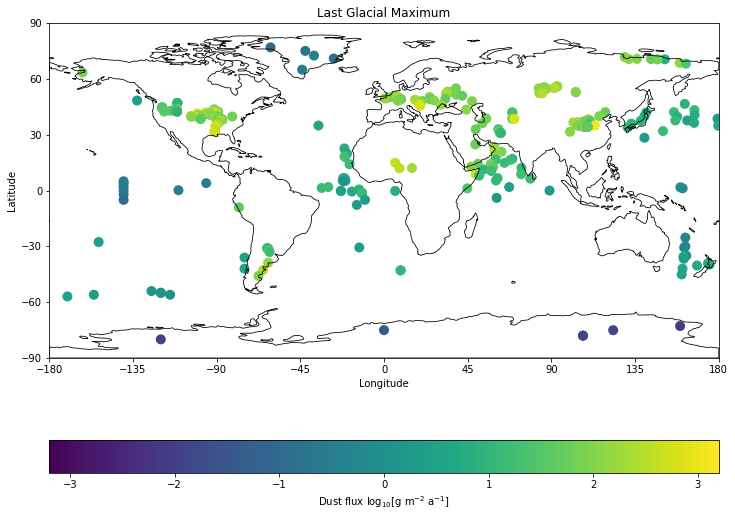

In [5]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [6]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

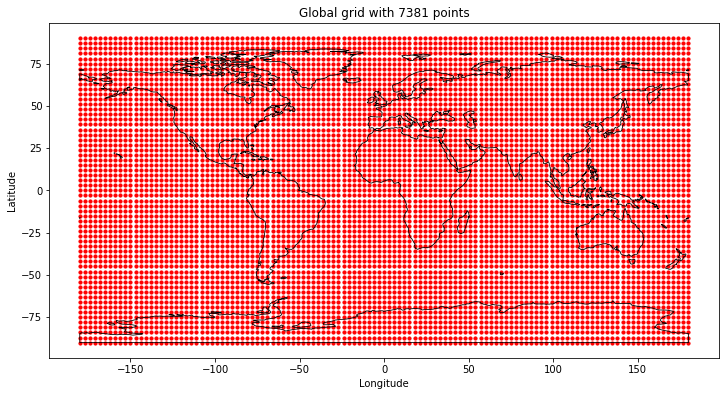

In [7]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [8]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [9]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    radio = 6371 #el radio de la tierra en kilometros
    
    distancia = radio * np.arccos(np.sin(np.radians(x[1]))*np.sin(np.radians(y[1])) + np.cos(np.radians(x[1]))*np.cos(np.radians(y[1]))*np.cos(np.radians(y[0]-x[0])))
    
    return distancia

In [10]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [11]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [12]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

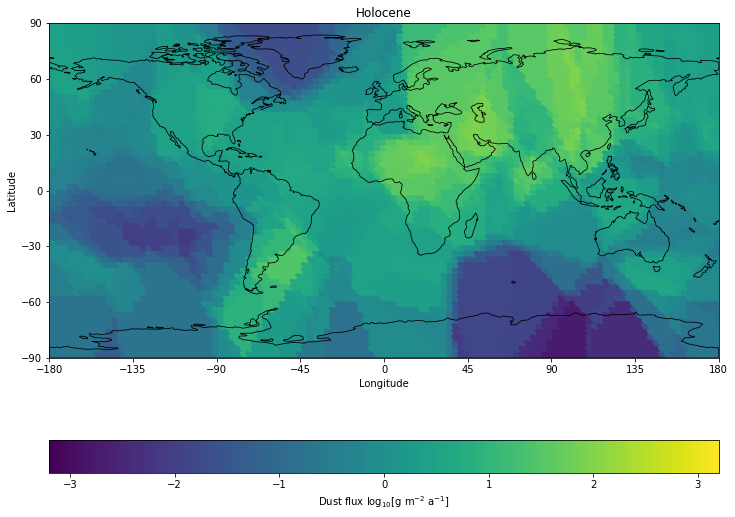

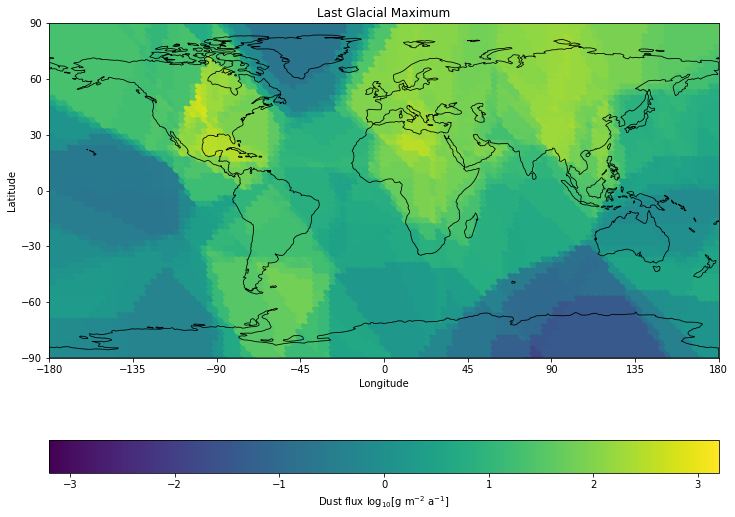

In [13]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

### Resolucion tarea 

3.- Implementacion de funcion para el calculo de la distancia geodesica aplicada al df de HOLOCENE y LGM <br>
4.- Visualizar el resultado de la distancia

In [14]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

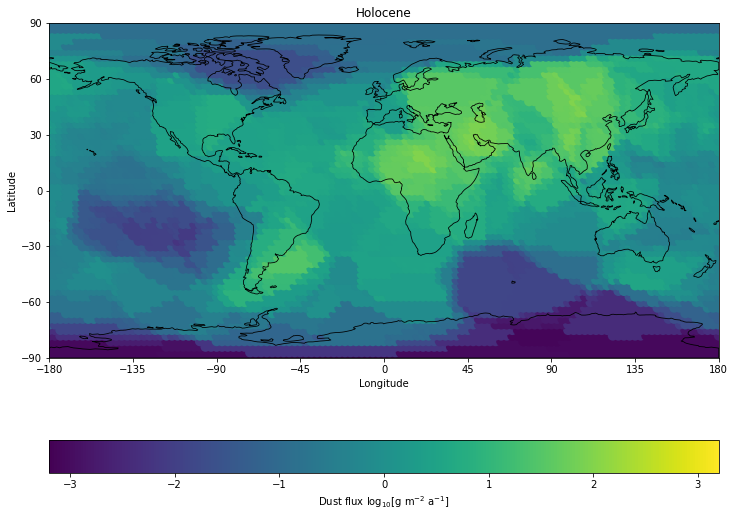

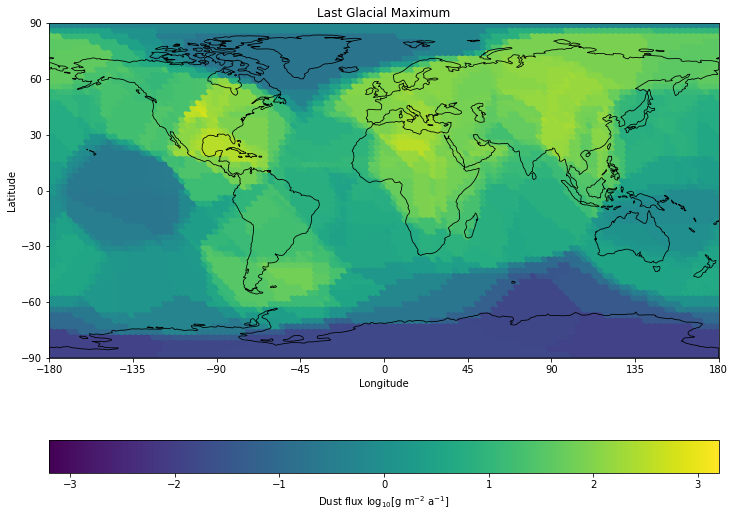

In [15]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_geodesic',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_geodesic',
                         label_str='est_lgm')

5.- Calcular la diferencia entre ambos metodos y visualizar la diferencia

## Se asume que por lo menos se corrio el codigo del item anterior, ya que si no puede haber problemas en la tabla por la falta de la columna de geometria

In [16]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol_euclideana"] = estimations_holocene
df_global_grid["est_lgm_euclideana"] = estimations_lgm


estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geodesica"] = estimations_holocene
df_global_grid["est_lgm_geodesica"] = estimations_lgm

if "est_hol" in df_global_grid.columns:
        df_global_grid = df_global_grid.drop("est_hol", axis=1)

if "est_lgm" in df_global_grid.columns:
        df_global_grid = df_global_grid.drop("est_lgm", axis=1)
        


In [17]:
#añadimos la diferencia entre las dif medidas para los periodos
df_global_grid['diferencia_distancias_holocene'] = np.abs(df_global_grid['est_hol_geodesica'] - df_global_grid['est_hol_euclideana'])
df_global_grid['diferencia_distancias_lgm'] = np.abs(df_global_grid['est_lgm_geodesica'] - df_global_grid['est_lgm_euclideana'])
#reordenamos el dataset para que sea más facil de ver la relacion entre las distancias
nuevo_orden = ['lon', 'lat', 'geometry', 'est_hol_euclideana','est_hol_geodesica','diferencia_distancias_holocene',
               'est_lgm_euclideana','est_lgm_geodesica','diferencia_distancias_lgm']
#nuestro dataset final
df_reordenado = df_global_grid[nuevo_orden]
df_reordenado

,lon,lat,geometry,est_hol_euclideana,est_hol_geodesica,diferencia_distancias_holocene,est_lgm_euclideana,est_lgm_geodesica,diferencia_distancias_lgm
0,-180.0,-90.0,POINT (-180.00000 -90.00000),-0.736623,-3.034526,2.297903,-0.111441,-1.804872,1.693431
1,-177.0,-90.0,POINT (-177.00000 -90.00000),-0.736623,-3.034526,2.297903,-0.111441,-1.804872,1.693431
2,-174.0,-90.0,POINT (-174.00000 -90.00000),-0.736623,-3.034526,2.297903,-0.175193,-1.804872,1.629679
3,-171.0,-90.0,POINT (-171.00000 -90.00000),-0.736623,-3.034526,2.297903,-0.175193,-1.804872,1.629679
4,-168.0,-90.0,POINT (-168.00000 -90.00000),-0.740268,-3.034526,2.294258,-0.175193,-1.804872,1.629679
...,...,...,...,...,...,...,...,...,...
7376,168.0,90.0,POINT (168.00000 90.00000),0.388114,-0.889438,1.277551,1.583464,-0.272050,1.855513
7377,171.0,90.0,POINT (171.00000 90.00000),0.388114,-0.889438,1.277551,1.583464,-0.272050,1.855513
7378,174.0,90.0,POINT (174.00000 90.00000),0.388114,-0.889438,1.277551,1.583464,-0.272050,1.855513
7379,177.0,90.0,POINT (177.00000 90.00000),0.388114,-0.889438,1.277551,1.583464,-0.272050,1.855513


Ahora visualizamos la diferencia en el mapa

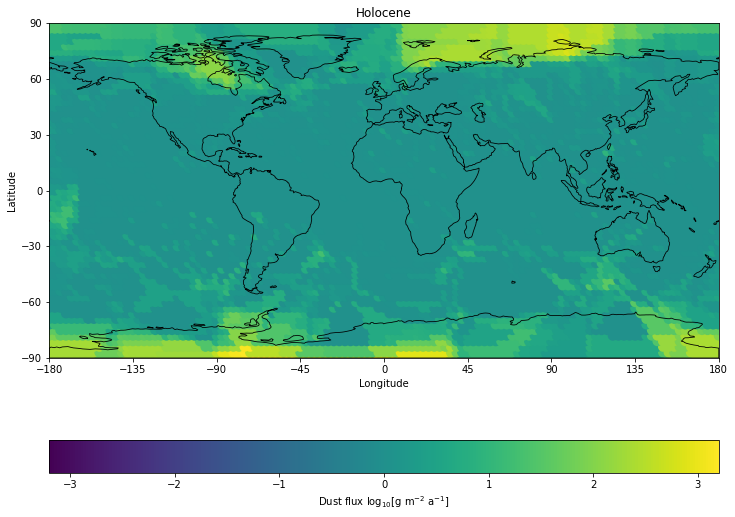

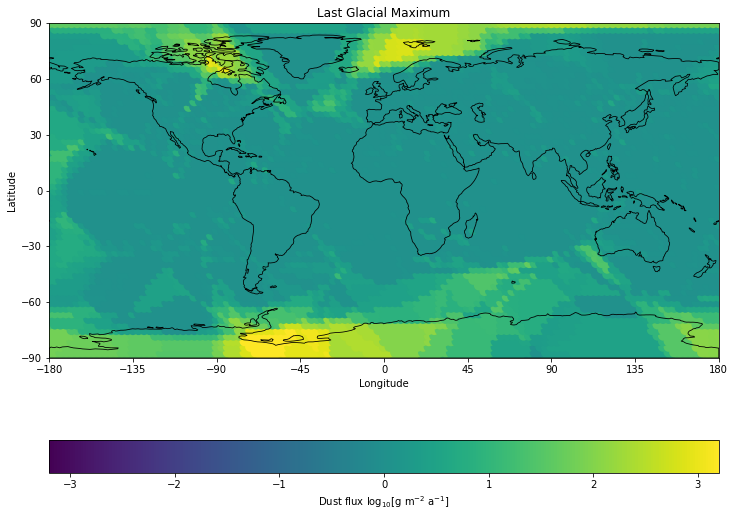

In [18]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_diferencia',
                         label_str='diferencia_distancias_holocene')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_diferencia',
                         label_str='diferencia_distancias_lgm')

6.- Discutir los resultados

a)¿Por qué las diferencias son más grandes en una parte que otra parte del mundo? <br>
R: Si analizamos los graficos de las diferencias, notaremos que existe una mayor diferencia en los polos, esto se puede deber principalmente a que tenemos menos puntos para comparar en estos sectores por lo que la variabilidad erradica totalmente en el metodo utilizado para calcular la aproximacion, y si vemos las aproximaciones euclideanas no alcanzaron a abacar bien estos sectores, a diferencia de la distancia geodesica que si logra capturar una aproximacion más cercana de estas partes del mundo. En cambio en el resto del planeta, existen mayores registros por lo que es factible considerar que los al realizar la diferencia entre la distancia euclideana y geodesica sean más cercanas  <br><br>
b)¿Cuál método es más fidedigno en los polos sur y norte? <br>
R: El metodo más fidedigno es con la distancia geodesica, esto se debe principalmente a que este tipo de medicion tiene en consideracion la curvatura de la tierra, el metodo euclidiano ignora esto y plantea una linea recta <br><br>
c)¿Cuál método es más fidedigno en longitud 180◦?<br>
R:El metodo más fidedigno nuevamente es la distancia geodesica,y por el mismo argumento anterior, la distancia geodesica toma en cuenta la curvatura de la tierra para hacer sus calculos, por lo que se toman en consideracion este "reccorido" cuando se calcula la distancia entre un punto y otro<br><br>
d)¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?<br>
R:El principal argumento para denotar la diferencia entre los resultados obtenidos en la epoca del Holoceno y el LGM, en un principio tiene que ver con lo "mapas"(realmente son los puntos que tenemos en los archivos csv, pero visualmente se entiende más en el mapa .pdf) que usamos de referencia para realizar las aproximaciones.<br> Si comparamos ambos mapas (guardados en los archivos DATA_MAP_LGM" y "DATA_MAP_HOLOCENE") notaremos que hay menos registros en la epoca del LGM y se encuentran muy cercanos los unos de los otros, mientras que por el lado de los registros del HOLOCENO, tenemos muchos más registros de la deposicion de polvo y los puntos se encuentran más repartidos en el mundo, por lo que cuando calculemos  la aproximacion para los puntos de nuestra grilla, se podra realizar la aproximacion tomando distintos puntos cercanos con distintos valores asignados (tendremos más registros para comparar y obtener una aproximacion más certera, principalmente debido a la variedad que tendremos en nuestra muestra)  <br><br>
e)¿Cómo elegir el número de vecinos cercanos? <br>
R:En programacion existen metodos que permiten ver cuantos vecinos pueden ser los optimos para calcular (por ejemplo cross validation) si quisieramos saber si aumentar o disminuir los vecinos con que hacemos la muestra, podriamos probar cual resultado nos parece más optimo, pero hay que considerar que:<br>
* Si disminuimos el numero de vecinos es muy probable que nuestra aproximacion no sea muy buena, dado que no tendremos muchos valores con los cuales comparar resultados, por ejemplo si solo utilizaramos un vecino, tendriamos siempre un resultado muy cercano al vecino con el cual nos comparamos(se realizaria un sobre ajuste sobre nuestros resultados).
* Por otro lado si aumentamos mucho la cantidad de vecinos con los que nos comparamos, es muy probable que tambien obtengamos resultados distorsionados, dado que estaremos tomando a vecinos que no necesariamente estaran tan cerca de nostros, por lo que realmente su valor no deberia de tener mucha influencia sobre nosotros (ya que no nos aportan mucha informacion) pero si los consideramos al calcular, van a estar influyendo en las aproximaciones que realizamos, y probablemente influyan de forma negativa, ya que obtendremos resultados poco realistas<br><br>